# 1. Probabilistic dynamic motion primitives.

Extension to DMP in probabilistic sense. 

# 2. Key Papers.

1. Paraschos et al.: Probabilistic movement primitives, NeurIPS (2013),
    https://papers.nips.cc/paper/2013/file/e53a0a2978c28872a4505bdb51db06dc-Paper.pdf

2. Maeda et al.: Probabilistic movement primitives for coordination of
    multiple human–robot collaborative tasks, AuRo 2017,
    https://link.springer.com/article/10.1007/s10514-016-9556-2

3. Paraschos et al.: Using probabilistic movement primitives in robotics, AuRo (2018),
    https://www.ias.informatik.tu-darmstadt.de/uploads/Team/AlexandrosParaschos/promps_auro.pdf,
    https://link.springer.com/article/10.1007/s10514-017-9648-7

4. Lazaric et al.: Bayesian Multi-Task Reinforcement Learning, ICML (2010),
    https://hal.inria.fr/inria-00475214/document

# 3. Toy problem.

3.1. Generation of artificial 2-dim data, representing some curves in 2d. Based on expert's trajectories we want to learn how to draw something.  They are used to initialize probabilistic DMP. "True" trajectory is painted in red.

In [217]:
import sys
sys.path.append('../movement_primitives/')

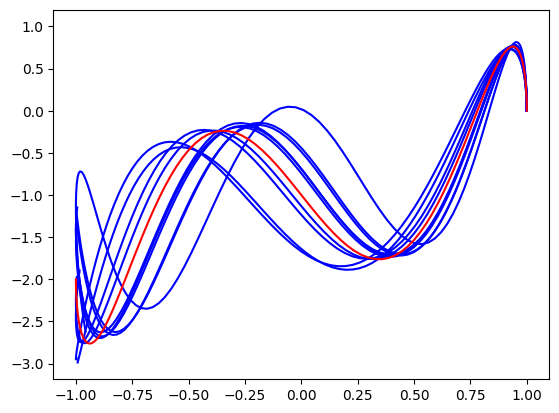

In [197]:
n_steps = 100
n_demos = 10
dimensionality = 2
# potentially each trajectory could be sampled at different timestamps
TT = np.array([np.linspace(0, 1, n_steps) for _ in range(n_demos)])
def generate_2d_demo(n_steps, demo_idx, X_noise=0.05, Y_noise=0.1):
    r1 = np.random.randn() * X_noise
    r2 = np.random.randn() * Y_noise
    time = TT[demo_idx,:]    
    X = np.ndarray((n_steps, dimensionality))
    
    X[:, 0] = np.cos((1+r1) * np.pi*time)
    X[:, 1] = np.sin((1+r2) * 4*np.pi*time)-2*np.linspace(0, 1, n_steps)    
    return X
# True median trajectory
fact = np.ndarray((n_steps, dimensionality))
fact[:, 0] = np.cos(np.pi*TT[0,:])
fact[:, 1] = np.sin(4*np.pi*TT[0,:])-2*np.linspace(0, 1, n_steps)


demos = np.array([generate_demo(n_steps,demo_idx) for demo_idx in range(n_demos)])
#test_trajectory = np.array([generate_demo(n_steps,demo_idx) for demo_idx in range(2)])
for demo in demos:
    plt.plot(demo[:, 0], demo[:, 1], color="b")
    
plt.plot(fact[:, 0], fact[:, 1], color="r")
#plt.plot(test_trajectory[:, 0], test_trajectory[:, 1], color="g")

Initialize probabilistic MDP object.

In [84]:
n_weights_per_dim = 50
promp = ProMP(n_dims=dimensionality, n_weights_per_dim=n_weights_per_dim)

In [248]:
demos.shape

(10, 100, 2)

Fit probabilistic DMP to generated trajectories.

In [85]:
promp.imitate(TT, demos, verbose=1)

Iteration 0001: delta = 1.97947
Iteration 0002: delta = 8.85303
Iteration 0003: delta = 0.172315
Iteration 0004: delta = 0.000215712
Iteration 0005: delta = 4.54914e-07


Generate new samples of trajectories by using probabilistic DMPs.  Compute mean trajectory and variance for them. Use one trajsctory(painted in black) as a testing trajectory to compute similarity score.

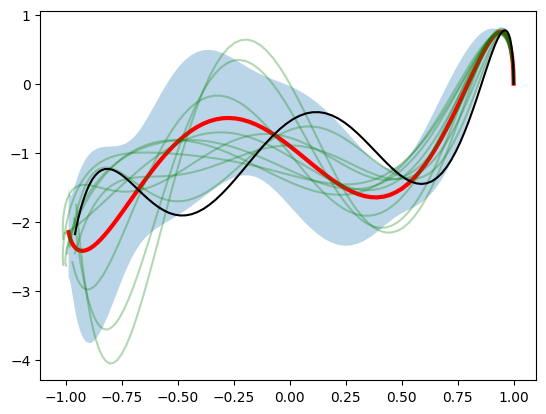

In [190]:
random_state = np.random.RandomState(1)
samples = promp.sample_trajectories(TT[0], 10, random_state)

mean_trajectory = promp.mean_trajectory(TT[0])
plt.plot(mean_trajectory[:,0], mean_trajectory[:,1], label="Reproduction", c="r", lw=3)
var_trajectory = np.sqrt(promp.var_trajectory(TT[0]))
factor = 2
plt.fill_between(
        mean_trajectory[:, 0],
        mean_trajectory[:, 1] - factor * var_trajectory[:, 1],
        mean_trajectory[:, 1] + factor * var_trajectory[:, 1],
        alpha=0.3)
for sample in samples:
    plt.plot(sample[:,0], sample[:,1], c="g", alpha=0.3)

plt.plot(test_trajectory[0,:,0], test_trajectory[0,:,1], c="black")
plt.show()

Define a score function, representing a measure of deviation of the tested trajectory from the mean trajectory.
In particular: if tested traiectory is beyond a specified threshould in terms of variance from the mean trajectory, we penelize the perfect score.

In [187]:
random_state = np.random.RandomState(35)
test_trajectory = promp.sample_trajectories(TT[0], 1, random_state)

In [215]:
def similarity_score(test_sample, mean_trajectory, var_trajectory, threshold=2.0):
    deviation = test_sample - mean_trajectory
    factors = np.abs(deviation)/(var_trajectory)
    avg_extreme = np.sum([factors>threshold])/(factors.shape[1]*factors.shape[0])
    return 1 - avg_extreme

In [216]:
score = similarity_score(test_trajectory[0], mean_trajectory, var_trajectory)
print(f"Current score : {score}")

Current score : 0.88


# 4. Experiment with real dataset.

In [218]:
import c3d
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D

Load sensor data of person, waiving one hand from :
https://tele-immersion.citris-uc.org/berkeley_mhad#mvmts


In [ ]:
# read Motion Capture data
reader = c3d.Reader(open('../dataset/moc_s01_a06_r01.c3d', 'rb'))
data = reader.read_frames()
data = list(data)

data = [data[i][1][:, 0:3] for i in range(np.int(np.ceil(len(data))))]
data = np.array(data)

# Sample and smooth
data = data[1000:1600]
data = np.concatenate((data, data, data))

data = savgol_filter(data, 401, 3, axis=0)
data = savgol_filter(data, 401, 3, axis=0)
# make all values positive
data += 1000

n_frames = data.shape[0]

In [238]:
# indices of links inside of dataset
head = 0
back = np.arange(3, 7)
left_hand = np.arange(11, 19)
right_hand = [19, 20, 21, 22, 24]
left_leg = [27, 28, 30, 31, 32, 33, 34]
right_leg = [35, 37, 38, 39, 40, 41, 42]

Generate time array.

In [250]:
n_demos = 5
n_steps = data.shape[0]
TT = np.array([np.linspace(0, 1, n_steps) for _ in range(n_demos)])

# Learn quasi-periodic 3D trajectory from demonstration.

In [241]:
# Trajectory of human's hand
traj_x = data[:, right_hand[-1], 0]
traj_y = data[:, right_hand[-1], 1]
traj_z = data[:, right_hand[-1], 2]
# Adjust initial coordinates
traj_x = traj_x - traj_x[0]
traj_y = traj_y - traj_y[0]
traj_z = traj_z - traj_z[0]

In [256]:
n_steps = traj_x.shape[0]
data_3d = np.ndarray((n_steps, dimensionality))
data_3d[:, 0] = traj_x
data_3d[:, 1] = traj_y
data_3d[:, 2] = traj_z

In [259]:
data_3d = np.expand_dims(data_3d, axis=0)

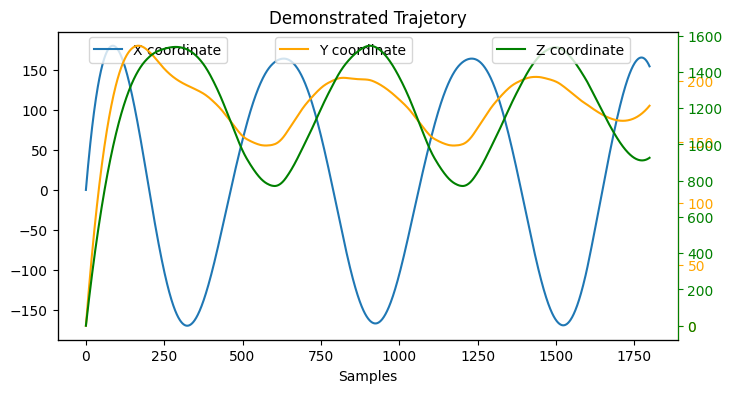

In [244]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(traj_x.shape[0]), traj_x, label="X coordinate")
ax2 = ax.twinx()
ax2.spines["right"].set_edgecolor("orange")
ax2.tick_params(axis='y', colors="orange")
ax2.plot(range(traj_y.shape[0]), traj_y, label="Y coordinate", c="orange")
ax3 = ax.twinx()
ax3.spines["right"].set_edgecolor("green")
ax3.tick_params(axis='y', colors="green")
ax3.plot(range(traj_z.shape[0]), traj_z, label="Z coordinate", c="green")
ax.legend(loc=(0.05, 0.9))
ax2.legend(loc=(0.35, 0.9))
ax3.legend(loc=(0.7, 0.9))
ax.set_xlabel("Samples")
plt.title("Demonstrated Trajetory")
plt.show()

XY-projection of the motion.

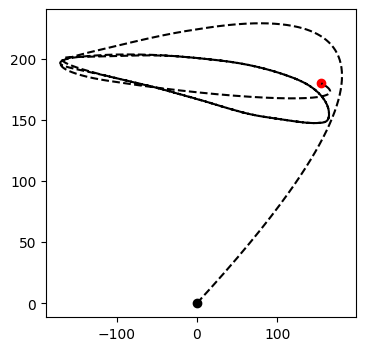

In [245]:
plt.figure(figsize=(4, 4))
plt.scatter([traj_x[0]], [traj_y[0]], c="k")
plt.scatter([traj_x[-1]], [traj_y[-1]], c="r")
plt.plot(traj_x, traj_y, c="k", linestyle="--")
plt.show()

Fit Probabilistic DMP to the trajectories. 

In [246]:
dimensionality=3
n_weights_per_dim = 50
promp = ProMP(n_dims=dimensionality, n_weights_per_dim=n_weights_per_dim)

In [ ]:
promp.imitate(TT, data_3d, verbose=1)